In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import itertools
from typing import Callable, Optional, Sequence, Tuple
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
# Read the CSV file
#data = pd.read_csv('/ceph/submit/data/user/a/ahmed95/minimalChern_NN/ferminet_2025_10_03_20:44:22/train_stats.csv')
data = pd.read_csv('/work/submit/ahmed95/data/8particles_withflux/0.5/train_stats.csv')
#data = pd.read_csv('/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_06_15:31:50/train_stats.csv')
#data = pd.read_csv('/work/submit/ahmed95/data/8particles_newrun1/None/train_stats copy.csv')

In [44]:
data

step     energy     ewmean     ewvar     pmove
0          0  39.928970  39.928970  0.000000  0.885449
1          1  39.689140  39.904987  0.005177  0.888184
2          2  39.618572  39.876347  0.012042  0.886035
3          3  39.441147  39.832825  0.027884  0.889551
4          4  39.442900  39.793830  0.038779  0.889258
...      ...        ...        ...       ...       ...
99087  99087  39.216870  39.251590  0.001522  0.514453
99088  99088  39.356476  39.262077  0.002359  0.519629
99089  99089  39.253082  39.261177  0.002131  0.516797
99090  99090  39.272972  39.262356  0.001930  0.521289
99091  99091  39.257320  39.261852  0.001739  0.526367

[99092 rows x 5 columns]

In [40]:
data['energy'] = data['energy'].str.replace(r'[()]', '', regex=True)
data.iloc[:, 1] = data.iloc[:, 1].apply(complex)

In [45]:
average = data.iloc[-4000:,1].mean()  # Access the second column by index (1)
print(average)

39.2455545615


In [41]:
average = data.iloc[-16796:,1].mean()  # Access the second column by index (1)
print(average)

(39.201692592224404+0.0003313128753711582j)


In [8]:
average = data.iloc[-5000:,1].mean()  # Access the second column by index (1)
print(average)

39.2463054958


In [ ]:
std_dev = data.iloc[-2000:,3].mean()  # Access the first column by index (0)
print(std_dev)

In [12]:
# Compute the standard deviation
std_dev = np.real(data.iloc[-15000:, 1]).std()
# Compute the sample size
sample_size = len(data.iloc[-15000:, 1])

# Compute the standard error of the mean (SEM)
sem = std_dev / np.sqrt(sample_size)

# Print the SEM
print(sem)

(0.0017146226695535025+0j)


In [11]:
data.iloc[-2000:, 1].values

array([39.297718, 39.125103, 39.19108 , ..., 39.10442 , 39.052094,
       39.146584], shape=(2000,))

In [28]:
np.array((data.iloc[-2000:, 1]).values)

array([39.297718, 39.125103, 39.19108 , ..., 39.10442 , 39.052094,
       39.146584], shape=(2000,))

In [14]:
7000*100

700000

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/numpy/_core/_methods.py:216: RuntimeWarning: invalid value encountered in divide
  ret = ret / rcount
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


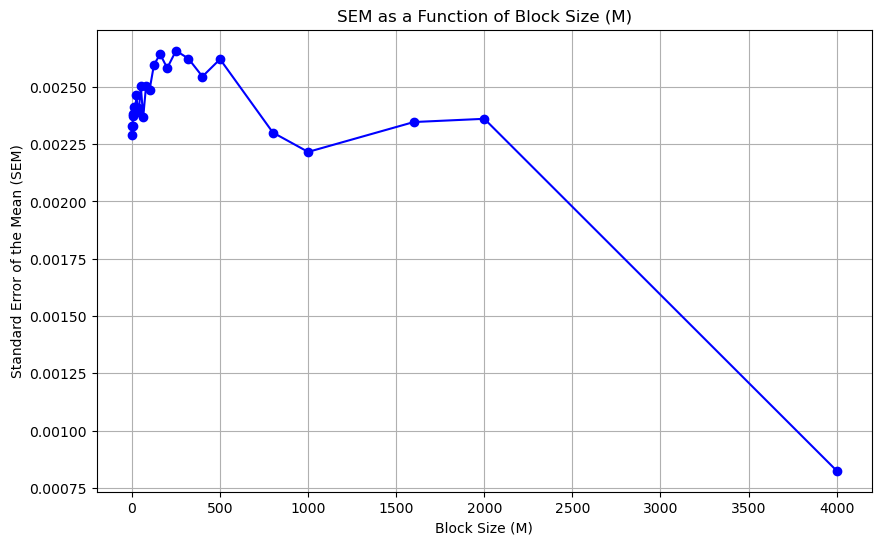

In [42]:
import numpy as np

# Define N as the total number of points
N = len(data.iloc[-8000:, 1])

# Define a function to compute SEM using blocking techniques
def compute_sem_blocking(data, M):
    # Ensure data is a NumPy array for easier manipulation
    data2 = np.array((data.iloc[-8000:, 1]).values)
    
    # Check if N is divisible by M
    if N % M != 0:
        raise ValueError("N must be divisible by M for blocking to work.")
    
    # Number of blocks
    num_blocks = N // M
    
    # Reshape data into blocks of size M
    blocks = data2[:num_blocks * M].reshape(num_blocks, M)
    
    # Compute the mean of each block
    block_means = blocks.mean(axis=1)
    
    # Compute the standard deviation of the block means
    std_dev_block_means = block_means.std(ddof=1)
    
    # Compute the SEM as the standard deviation of block means divided by sqrt(num_blocks)
    sem = std_dev_block_means / np.sqrt(num_blocks)
    
    return sem

# Example usage
# Generate a list of block sizes M that divide N evenly
block_sizes = [M for M in range(1, N + 1) if N % M == 0]

# Compute SEM for each block size
sem_values = [compute_sem_blocking(data, M) for M in block_sizes]

# Plot SEM as a function of M
plt.figure(figsize=(10, 6))
plt.plot(block_sizes, sem_values, marker='o', linestyle='-', color='b')
plt.xlabel('Block Size (M)')
plt.ylabel('Standard Error of the Mean (SEM)')
plt.title('SEM as a Function of Block Size (M)')
plt.grid(True)
plt.show()

/tmp/ipykernel_406028/157507845.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  rho[k] = num / ((N - k) * var)            # <-- key fix: N-k, not N


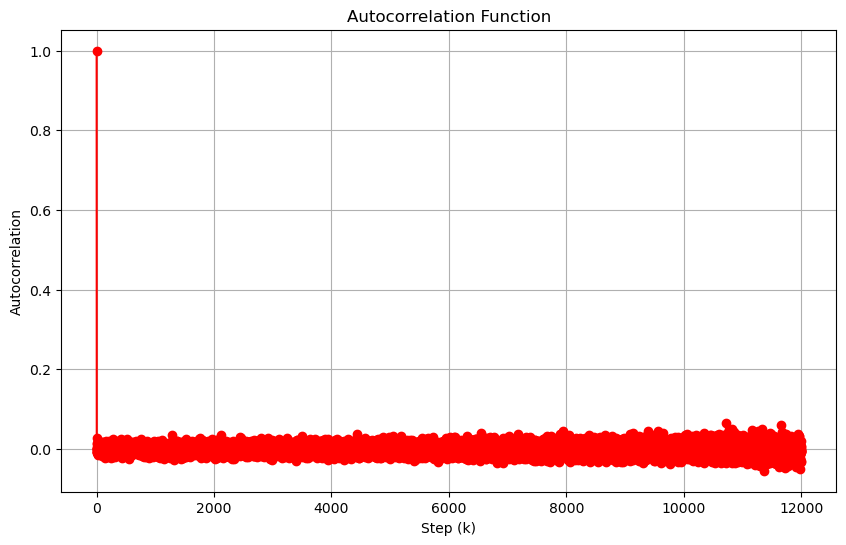

In [13]:
import numpy as np

def compute_autocorrelation(data, max_k=None):
    """
    Returns rho[k] for k = 0..max_k using the (unbiased) estimator:
      rho(k) = sum_{t=1}^{N-k} (x_t - x̄)(x_{t+k} - x̄) / [(N-k) * Var[x]]
    """
    x = np.asarray(data, dtype=complex)
    N = x.size
    if N < 2:
        raise ValueError("Need at least 2 points.")
    if max_k is None or max_k >= N:
        max_k = N - 1

    mu = x.mean()
    # population variance so that rho(0)=1 exactly with this normalization
    var = np.var(x)  
    if var == 0:
        return np.ones(max_k + 1)

    xc = x - mu
    rho = np.empty(max_k + 1, dtype=float)
    for k in range(max_k + 1):
        num = np.dot(xc[:N-k], xc[k:])            # sum over t=1..N-k
        rho[k] = num / ((N - k) * var)            # <-- key fix: N-k, not N
    return rho

# Example usage
data_array = data.iloc[-15000:, 1].apply(lambda x: x.real)  # Extract data as a NumPy array
max_k = 12000  # Maximum step k
autocorrelations = compute_autocorrelation(data_array, max_k)

# Plot the autocorrelation function
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(max_k + 1), autocorrelations, marker='o', linestyle='-', color='r')
plt.xlabel('Step (k)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.grid(True)
plt.show()

np.float64(39.421352)

In [42]:
import numpy as np

def iact_sokal(x, c=5.0, max_lag=None, return_details=False):
    """
    Integrated autocorrelation time (IACT) using Sokal's automatic window.
    Works directly on your per-step means y_t.

    Args
    ----
    x : array_like
        1D time series (burn-in removed).
    c : float
        Window constant; 4–10 is common. Larger => more conservative.
    max_lag : int or None
        Optional hard cap on the maximum lag to consider (<= N-1).
    return_details : bool
        If True, also returns dict with rho, K, Neff.

    Returns
    -------
    tau_int : float
        Estimated integrated autocorrelation time.
    details : dict (optional)
        {"rho": rho, "K": K, "Neff": Neff} where
        rho is the unbiased ACF (rho[0]=1), K is the truncation lag,
        Neff = N/(2*tau_int).
    """
    x = np.asarray(x, dtype=float)
    N = x.size
    if N < 2:
        raise ValueError("Need at least 2 points.")

    # mean-center
    xc = x - x.mean()
    # population variance (so rho[0] = 1 exactly with our normalization)
    var = np.mean(xc * xc)
    if var == 0.0:
        tau = 1.0
        if return_details:
            return tau, {"rho": np.array([1.0]), "K": 0, "Neff": float(N)/(2*tau)}
        return tau

    # Unbiased autocorrelation via direct correlate (OK up to ~1e5 length)
    cfull = np.correlate(xc, xc, mode='full')
    cpos = cfull[N-1:]                           # length N, sums over t=0..N-1-k
    k = np.arange(N)
    rho = cpos / ((N - k) * var)                 # unbiased: divide by (N-k)*var
    rho[0] = 1.0

    if max_lag is None or max_lag >= N:
        max_lag = N - 1

    # Sokal's automatic window: iterate K ≈ c * tau until self-consistent
    tau = 1.0
    while True:
        K = min(int(max(1, np.floor(c * tau))), max_lag)
        # If rho goes noisy/negative, you can optionally stop earlier:
        # K = min(K, 1 + np.argmax(np.maximum.accumulate((rho[1:K+1] <= 0).astype(int))))
        tau_new = 1.0 + 2.0 * np.sum(rho[1:K+1])
        # guard against pathological negatives due to noise
        tau_new = max(1.0, float(tau_new))
        if K == int(np.floor(c * tau_new)) or abs(tau_new - tau) / tau_new < 1e-3:
            tau = tau_new
            break
        tau = tau_new

    if return_details:
        Neff = N / (tau)
        return tau, {"rho": rho[:max_lag+1], "K": K, "Neff": Neff}
    return tau

In [43]:
tau, info = iact_sokal(data.iloc[-16796:, 1].apply(lambda x: x.real) , c=5, return_details=True)
Neff = info["Neff"]                 # effective independent steps
SE   = np.std(np.real(data.iloc[-16796:, 1].apply(lambda x: x.real) ) , ddof=1) * np.sqrt(2.0 * tau / len(data.iloc[-16796:, 1].apply(lambda x: x.real)))  # SEM of the mean
K    = info["K"]                    

In [48]:
20000*50

1000000

In [53]:
def compute_integrated_autocorrelation_time(data, max_k):
    """
    Compute the integrated autocorrelation time (IAT) from the autocorrelation function.

    Parameters:
    - data: 1D NumPy array of data points.
    - max_k: Maximum step k for which to compute the autocorrelation.

    Returns:
    - tau_int: The integrated autocorrelation time.
    """
    # Compute the autocorrelation function
    autocorrelations = compute_autocorrelation(data, max_k)
    
    # Compute the integrated autocorrelation time
    tau_int = 1 + 2 * np.sum(autocorrelations[1:])  # Skip R(0) for the summation
    print(2 * np.sum(autocorrelations[1:]))
    return tau_int

# Example usage
data_array = np.real(data.iloc[-3000:, 1].values)  # Extract data as a NumPy array
max_k = 3000  # Maximum step k
tau_int = compute_integrated_autocorrelation_time(data_array, max_k)
print(f"Integrated autocorrelation time: {tau_int}")

-1.0
Integrated autocorrelation time: 0.0


In [9]:
39.26036536375 + 0.01267471483891984

39.27304007858892

# Multiband ED vs NN

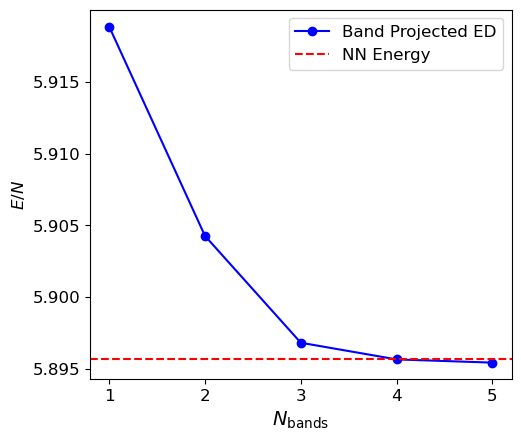

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Data for band energies
nbands = [1, 2, 3, 4, 5]
band_energies = np.array([17.756487727388514, 17.71279797550086, 17.690499151957038, 
                 17.687016842553835, 17.686346684906937])

# NN energy and standard deviation
nn_energy = 17.687037650821964
nn_std = 0.015602312296622506

# Plot band energies
plt.plot(nbands, band_energies / 3, marker='o', label='Band Projected ED', color='blue')

# Plot NN energy as a horizontal line
plt.axhline(nn_energy /3 , color='red', linestyle='--', label='NN Energy')

# Add shaded region for NN energy ± std
#plt.fill_between(nbands, nn_energy - nn_std, nn_energy + nn_std, color='red', alpha=0.2, label='NN Energy ± Std')
plt.xticks([1, 2, 3, 4, 5],fontsize = 12)
plt.yticks(fontsize =12)

# Add labels, legend, and title
plt.xlabel(r'$N_{\rm bands}$',fontsize = 14)
plt.ylabel(r'$E/N$ ',fontsize =12)
plt.legend(fontsize = 12)
plt.gca().set_aspect(150)  # Example: Set aspect ratio to 1.5
plt.savefig("plots_paper/NNvsED.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [28]:
# List of values for n
n_values = list(range(24))
n_values.append("None")
# Initialize an empty list to store the results
results = []

for n in n_values:
    # Construct the file path dynamically
    file_path = f"/work/submit/ahmed95/data/8particles_inference/{n}/train_stats.csv"
    
    try:
        # Load the data
        data = pd.read_csv(file_path)
        
         #Process the 'energy' column
        data['energy'] = data['energy'].str.replace(r'[()]', '', regex=True)
        data.iloc[:, 1] = data.iloc[:, 1].apply(complex)
        
        # Calculate the average of the second column
        average = data.iloc[:, 1].mean()
        std_dev = np.real(data.iloc[:, 1]).std()/np.sqrt(len(data.iloc[:, 1]))
        
        # Append the result as a tuple (n, average, std_dev) to the results list
        results.append([n, average, std_dev])
    except FileNotFoundError:
        print(f"File not found for n = {n}: {file_path}")
    except Exception as e:
        print(f"An error occurred for n = {n}: {e}")

# Convert the results list into a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['n', 'average','SEM'])

# Sort results_df by the 'average' column in descending order
#results_df = results_df.sort_values(by='average', ascending=True)

# Print the sorted DataFrame
print(results_df)

File not found for n = 0: /work/submit/ahmed95/data/8particles_inference/0/train_stats.csv
File not found for n = 2: /work/submit/ahmed95/data/8particles_inference/2/train_stats.csv
File not found for n = 4: /work/submit/ahmed95/data/8particles_inference/4/train_stats.csv
File not found for n = 6: /work/submit/ahmed95/data/8particles_inference/6/train_stats.csv
File not found for n = 7: /work/submit/ahmed95/data/8particles_inference/7/train_stats.csv
File not found for n = 8: /work/submit/ahmed95/data/8particles_inference/8/train_stats.csv
File not found for n = 9: /work/submit/ahmed95/data/8particles_inference/9/train_stats.csv
File not found for n = 10: /work/submit/ahmed95/data/8particles_inference/10/train_stats.csv
File not found for n = 11: /work/submit/ahmed95/data/8particles_inference/11/train_stats.csv
File not found for n = 12: /work/submit/ahmed95/data/8particles_inference/12/train_stats.csv
File not found for n = 14: /work/submit/ahmed95/data/8particles_inference/14/train_s

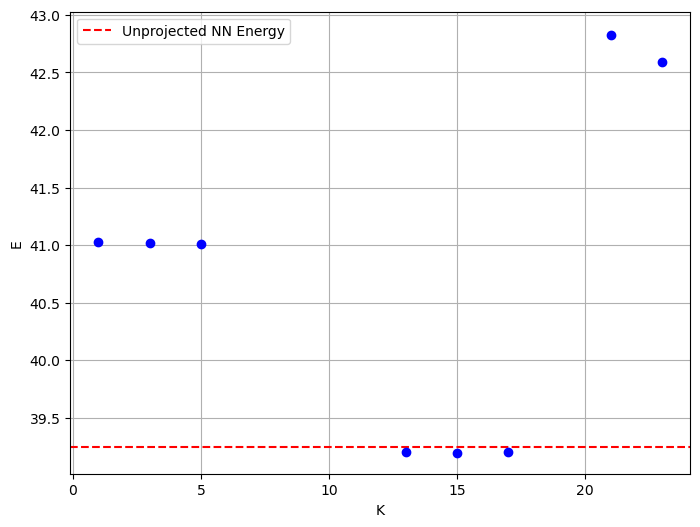

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Extract columns
x_values = results_df["n"]
y_values = results_df["average"].apply(np.real)  # Take the real part of the second column
error_bars = results_df["SEM"].apply(np.real)  # Take the real part of the SEM

# Plot
plt.figure(figsize=(8, 6))

for i, x in enumerate(x_values):
    if x == "None":
        # Plot horizontal line for "None"
        plt.axhline(y=y_values[i], color="red", linestyle="--",label ="Unprojected NN Energy")
    else:
        # Plot data point with error bar
        plt.errorbar(x, y_values[i], yerr=error_bars[i], fmt="o", c ="blue")

# Labels and legend
plt.xlabel("K")
plt.ylabel("E")
plt.grid()
plt.legend()
#plt.ylim(39.19,39.21)
# Show plot
plt.show()

In [23]:
error_bars

4    0.001463+0.000000j
3    0.001588+0.000000j
5    0.001504+0.000000j
8    0.001321+0.000000j
2    0.010683+0.000000j
1    0.010815+0.000000j
0    0.010724+0.000000j
7    0.016020+0.000000j
6    0.016659+0.000000j
Name: SEM, dtype: complex128

In [35]:
momlist = np.array([13,15,17])
avgenergy = np.array([results_df.iloc[0,1],results_df.iloc[1,1],results_df.iloc[2,1]])
unprojenergy = results_df.iloc[3,1]

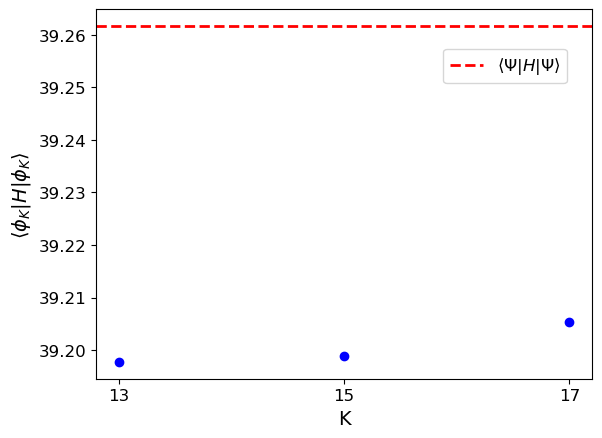

In [53]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(momlist, avgenergy, marker='o', linestyle='-', color='b')
plt.axhline(y=unprojenergy, color='r', linestyle='--', linewidth=2, label=r'$\langle \Psi|H|\Psi \rangle$')
# Add labels and title with increased font size
plt.xlabel('K', fontsize=14)
plt.ylabel(r'$\langle \phi_K|H|\phi_K \rangle$', fontsize=14)
custom_ticks = [13, 15, 17]
#custom_labels = [r'$\phi_{13}$',r'$\phi_{15}$', r'$\phi_{17}$']
plt.xticks(custom_ticks, fontsize=12)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12,loc=(0.7, 0.8))
plt.savefig("plots_paper/EDspectrum.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [13]:
 results_df.iloc[3,1]

np.float64(39.261837981)

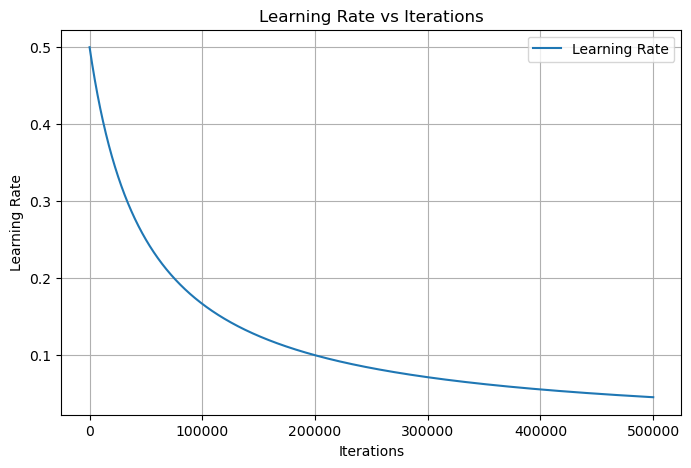

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_rate(initial_lr, decay, delay, total_iterations):
    """
    Plots the learning rate as a function of iterations using the formula:
    lr(t) = initial_lr * (1 + t / delay) ** -decay

    Args:
        initial_lr (float): Initial learning rate (η).
        decay (float): Decay exponent (x).
        delay (float): Delay parameter (t_0).
        total_iterations (int): Total number of iterations (t).
    """
    def learning_rate(t):
        return initial_lr * (1 + t / delay) ** -decay

    # Generate iterations and compute learning rates
    iterations = np.arange(total_iterations)
    lrs = np.array([learning_rate(t) for t in iterations])

    # Plot the learning rate
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, lrs, label="Learning Rate")
    plt.xlabel("Iterations")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate vs Iterations")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
plot_learning_rate(initial_lr=0.5, decay=1.0, delay=50000.0, total_iterations=500000)

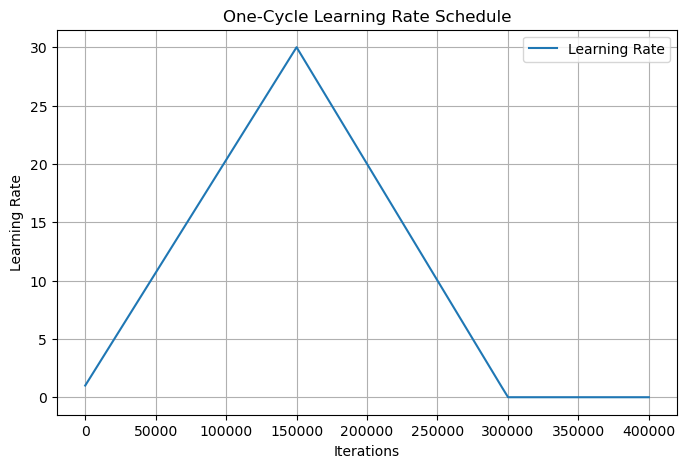

In [16]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Learning rate schedule function
def learning_rate_schedule(t_: jnp.ndarray, onecycle_steps: int, lr_start: float, lr_max: float, lr_end: float) -> jnp.ndarray:
    """One-cycle learning rate schedule."""
    progress = t_ / onecycle_steps

    def lr_onecycle_fn(progress):
        """Learning rate schedule function."""
        return jnp.where(
            progress < 0.5,
            lr_start + (lr_max - lr_start) * 2.0 * progress,
            lr_max - (lr_max - lr_end) * (2.0 * progress - 1.0)
        )

    return jnp.where(t_ <= onecycle_steps, lr_onecycle_fn(progress), lr_end)

# Plotting function
def plot_onecycle_learning_rate(onecycle_steps: int, lr_start: float, lr_max: float, lr_end: float):
    """
    Plots the learning rate as a function of iterations using the one-cycle schedule.
    """
    # Generate iterations
    total_iterations = onecycle_steps + 100000  # Include some steps beyond one cycle
    iterations = jnp.arange(total_iterations)

    # Compute learning rates
    lrs = learning_rate_schedule(iterations, onecycle_steps, lr_start, lr_max, lr_end)

    # Plot the learning rate
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, lrs, label="Learning Rate")
    plt.xlabel("Iterations")
    plt.ylabel("Learning Rate")
    plt.title("One-Cycle Learning Rate Schedule")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
plot_onecycle_learning_rate(
    onecycle_steps=300000,  # Total steps for one cycle
    lr_start=1.0,        # Starting learning rate
    lr_max=30.0,           # Maximum learning rate
    lr_end=00.0001          # Ending learning rate
)

/tmp/ipykernel_3304025/134060638.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


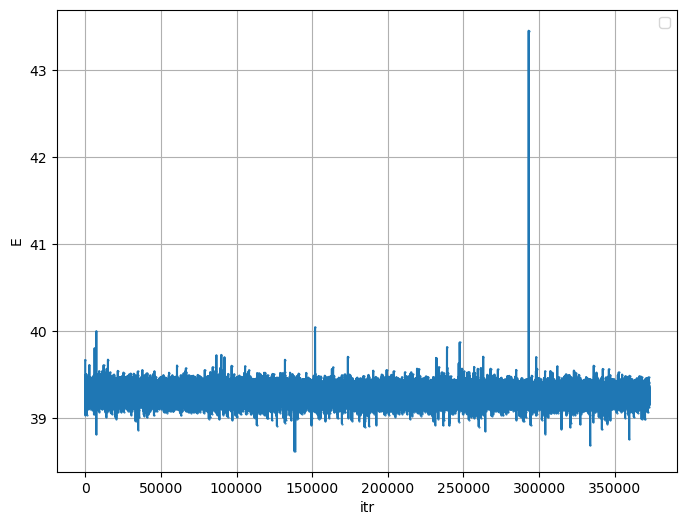

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `data` is a Pandas DataFrame
x = data.iloc[:, 0]  # First column (iterations)
y = data.iloc[:, 1]  # Second column (values)

# Compute the moving average (cumulative average)
#y_moving_avg = y.expanding().mean()

# Plot x vs moving average of y
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', markersize=0.5)
plt.xlabel('itr')
plt.ylabel('E')
#plt.axhline(y=17.756487779528502 , color='red', linestyle='--')
#plt.axhline(y=21.94179407979651 , color='red', linestyle='--')
#plt.xlim(6000,10000)
#plt.ylim(21.8,22.6)
plt.grid(True)
plt.legend()
plt.show()

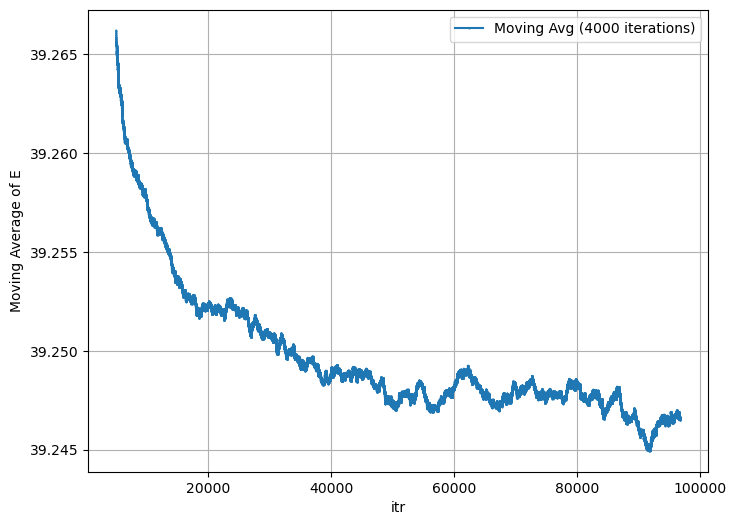

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `data` is a Pandas DataFrame
x = data.iloc[:, 0]  # First column (iterations)
y = data.iloc[:, 1]  # Second column (values)

# Compute the moving average over the last 100 iterations
y_moving_avg = y.rolling(window= 5000).mean()

# Plot x vs moving average of y
plt.figure(figsize=(8, 6))
plt.plot(x, y_moving_avg, marker='o', linestyle='-', markersize=0.5, label='Moving Avg (4000 iterations)')
#plt.axhline(y=21.94179407905313, color='red', linestyle='--')
#plt.axhline(y=30.409901406794223 , color='red', linestyle='--')
#plt.axhline(y=43.663175583218 , color='red', linestyle='--')
#plt.axhline(y = 39.34564426575877, color='red', linestyle='--')
#plt.axhline(y = 38.88301983948136, color='red', linestyle='--')
#plt.axhline(y =  0.0, color='red', linestyle='--')
plt.xlabel('itr')
plt.ylabel('Moving Average of E')
plt.grid(True)
#plt.xlim(60000,120000)
#plt.ylim(44.075,44.1)
plt.legend()
plt.show()


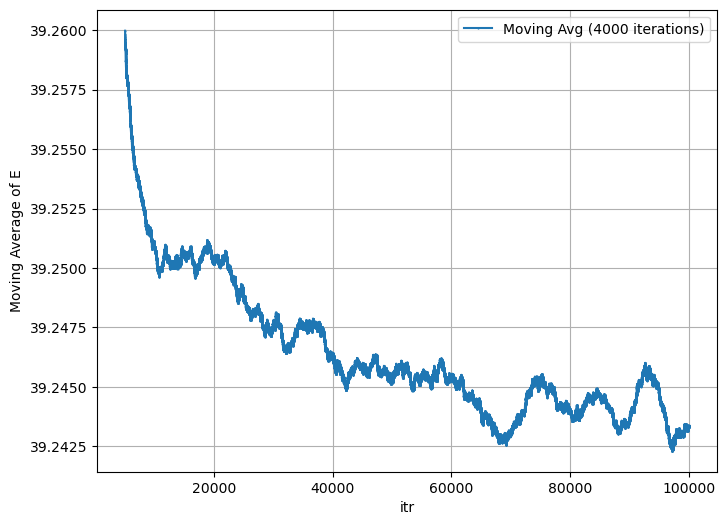

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `data` is a Pandas DataFrame
x = data.iloc[:, 0]  # First column (iterations)
y = data.iloc[:, 1]  # Second column (values)

# Compute the moving average over the last 100 iterations
y_moving_avg = y.rolling(window= 5000).mean()

# Plot x vs moving average of y
plt.figure(figsize=(8, 6))
plt.plot(x, y_moving_avg, marker='o', linestyle='-', markersize=0.5, label='Moving Avg (4000 iterations)')
#plt.axhline(y=21.94179407905313, color='red', linestyle='--')
#plt.axhline(y=30.409901406794223 , color='red', linestyle='--')
#plt.axhline(y=43.663175583218 , color='red', linestyle='--')
#plt.axhline(y = 39.34564426575877, color='red', linestyle='--')
#plt.axhline(y = 38.88301983948136, color='red', linestyle='--')
#plt.axhline(y =  0.0, color='red', linestyle='--')
plt.xlabel('itr')
plt.ylabel('Moving Average of E')
plt.grid(True)
#plt.xlim(60000,120000)
#plt.ylim(44.075,44.1)
plt.legend()
plt.show()


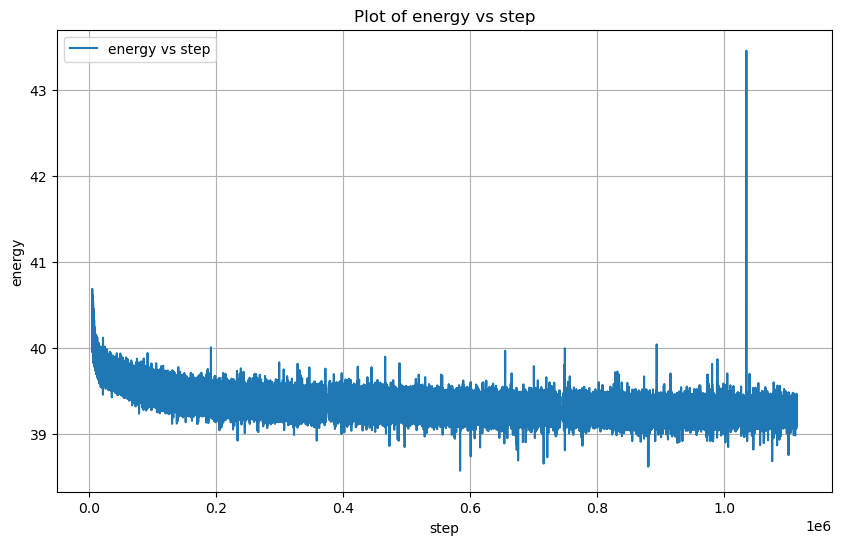

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def merge_and_plot(file_paths, x_column, y_column):
    """
    Merges data from multiple CSV files, neglects the first 5000 entries of each file,
    adjusts the step column, and plots the specified columns.

    Args:
        file_paths (list): List of file paths to CSV files.
        x_column (str): The column name to use as the x-axis.
        y_column (str): The column name to use as the y-axis.

    Returns:
        pd.DataFrame: The merged DataFrame.
    """
    merged_data = pd.DataFrame()
    last_step = 0

    for file_path in file_paths:
        # Load the data
        data = pd.read_csv(file_path)
        
        # Neglect the first 5000 entries
        data = data.iloc[5000:]
        
        # Adjust the step column to ensure it starts after the last step of the previous file
        if x_column in data.columns:
            data[x_column] += last_step
        
        # Update the last step for the next file
        if x_column in data.columns:
            last_step = data[x_column].max()
        
        # Append to the merged DataFrame
        merged_data = pd.concat([merged_data, data], ignore_index=True)

    # Extract x and y columns for plotting
    x = merged_data[x_column]
    y = merged_data[y_column]
    
    # Plot the specified columns
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, linestyle='-', label=f'{y_column} vs {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f'Plot of {y_column} vs {x_column}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return merged_data

# Example usage:
file_paths = [
    '/ceph/submit/data/user/a/ahmed95/minimalChern_NN/ferminet_2025_10_03_20:44:22/train_stats.csv',
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_12_15:12:48/train_stats.csv',
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_14_15:50:28/train_stats.csv'
]
merged_data = merge_and_plot(file_paths, x_column='step', y_column='energy')

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


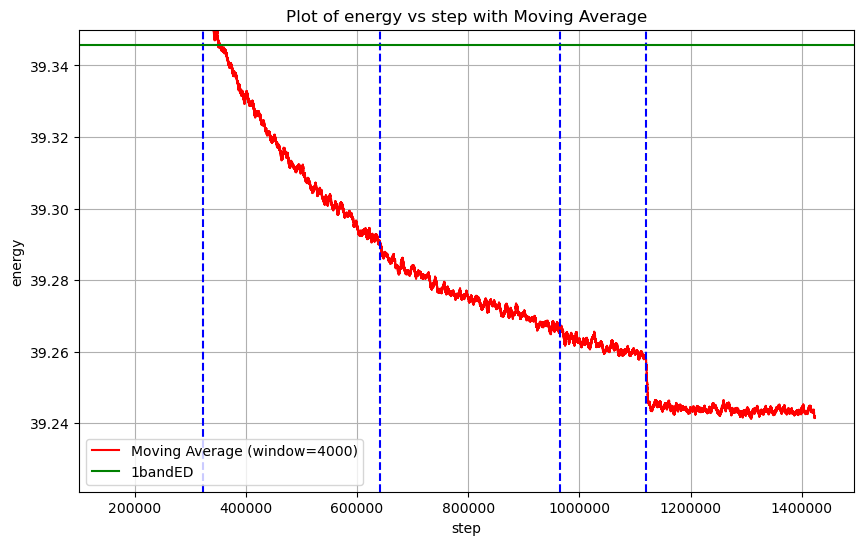

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def merge_and_plot_with_moving_average(file_paths, x_column, y_column, window_size, neglect, x_min=None, y_max=None, onebandEDenergy=None):
    """
    Merges data from multiple CSV files, neglects the first `neglect` entries of each file,
    adjusts the step column to ensure continuity, and plots the specified columns along with a moving average.

    Args:
        file_paths (list): List of file paths to CSV files.
        x_column (str): The column name to use as the x-axis.
        y_column (str): The column name to use as the y-axis.
        window_size (int): The window size for calculating the moving average.
        neglect (int): The number of rows to neglect from the start of each file.
        x_min (int, optional): The minimum value for the x-axis. If None, no limit is set.
        y_max (float, optional): The maximum value for the y-axis. If None, no limit is set.
        onebandEDenergy (float, optional): The value to plot as a horizontal line.

    Returns:
        pd.DataFrame: The merged DataFrame.
    """
    merged_data = pd.DataFrame()
    last_step = 0
    vertical_lines = []  # To store the step values for vertical lines

    for file_index, file_path in enumerate(file_paths):
        # Load the data
        data = pd.read_csv(file_path)
        
        # Neglect the first `neglect` entries
        data = data.iloc[neglect:]
        
        # Adjust the step column to ensure continuity
        if x_column in data.columns:
            data[x_column] = data[x_column] - data[x_column].iloc[0] + last_step
        
        # Add the starting step of the new data frame (except the first file) to vertical_lines
        if file_index > 0 and x_column in data.columns:
            vertical_lines.append(last_step)
        
        # Update the last step for the next file
        if x_column in data.columns:
            last_step = data[x_column].max()
        
        # Append to the merged DataFrame
        merged_data = pd.concat([merged_data, data], ignore_index=True)

    # Extract x and y columns for plotting
    x = merged_data[x_column]
    y = merged_data[y_column]
    
    # Calculate the moving average
    y_moving_avg = y.rolling(window=window_size).mean()
    
    # Plot the specified columns and moving average
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_moving_avg, color='red', label=f'Moving Average (window={window_size})')
    
    # Add vertical lines at the start of new data frames (from the second file onward)
    for line in vertical_lines:
        plt.axvline(x=line, color='blue', linestyle='--')
    
    # Plot the horizontal line for onebandEDenergy
    if onebandEDenergy is not None:
        plt.axhline(y=onebandEDenergy, color='green', linestyle='-', label='1bandED')
    
    # Set x-axis limits if x_min is provided
    if x_min is not None:
        plt.xlim(left=x_min)
    
    # Set y-axis limits if y_max is provided
    if y_max is not None:
        y_min, _ = plt.gca().get_ylim()
        plt.ylim(y_min, y_max)
    
    # Format the x-axis to avoid scientific notation
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f'Plot of {y_column} vs {x_column} with Moving Average')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return merged_data

# Example usage:
file_paths = [
    '/ceph/submit/data/user/a/ahmed95/minimalChern_NN/ferminet_2025_10_03_20:44:22/train_stats.csv',
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_12_15:12:48/train_stats.csv',
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_14_15:50:28/train_stats.csv', 
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_16_21:35:30/train_stats.csv',
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_18_10:11:32/train_stats.csv'
]
merged_data = merge_and_plot_with_moving_average(
    file_paths, 
    x_column='step', 
    y_column='energy', 
    window_size=4000, 
    neglect=50000, 
    x_min=100000,  # No limit for x-axis minimum
    y_max=39.35,  # No limit for y-axis maximum
    onebandEDenergy=39.34564426575877
)

Slope of segment starting at 0: -1.066692890942737e-06
Slope of segment starting at 362434: -2.2280770383597837e-07
Slope of segment starting at 721930: -6.555192393148428e-08
Slope of segment starting at 1084470: -3.9869589655358494e-08
Slope of segment starting at 1279884: -6.601900368964887e-09


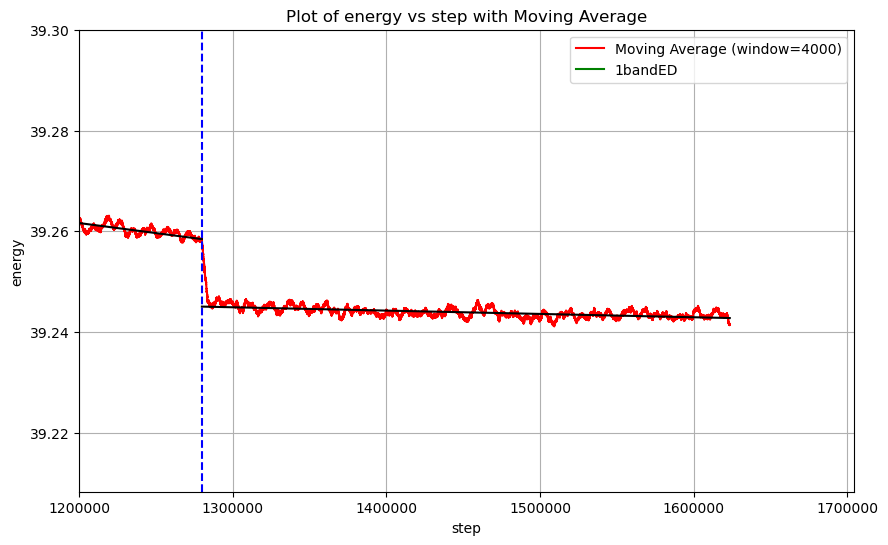

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def merge_and_plot_with_moving_average_and_fit(file_paths, x_column, y_column, window_size, neglect, x_min=None, y_max=None, onebandEDenergy=None):
    """
    Merges data from multiple CSV files, neglects the first `neglect` entries of each file,
    adjusts the step column to ensure continuity, plots the moving average,
    and fits a line to each dataset (separated by blue vertical lines).

    Args:
        file_paths (list): List of file paths to CSV files.
        x_column (str): The column name to use as the x-axis.
        y_column (str): The column name to use as the y-axis.
        window_size (int): The window size for calculating the moving average.
        neglect (int): The number of rows to neglect from the start of each file.
        x_min (int, optional): The minimum value for the x-axis. If None, no limit is set.
        y_max (float, optional): The maximum value for the y-axis. If None, no limit is set.
        onebandEDenergy (float, optional): The value to plot as a horizontal line.

    Returns:
        pd.DataFrame: The merged DataFrame.
        list: Slopes of the fitted lines for each segment.
    """
    merged_data = pd.DataFrame()
    last_step = 0
    vertical_lines = []  # To store the step values for vertical lines

    for file_index, file_path in enumerate(file_paths):
        # Load the data
        data = pd.read_csv(file_path)
        
        # Neglect the first `neglect` entries
        data = data.iloc[neglect:]
        
        # Adjust the step column to ensure continuity
        if x_column in data.columns:
            data[x_column] = data[x_column] - data[x_column].iloc[0] + last_step
        
        # Add the starting step of the new data frame (except the first file) to vertical_lines
        if file_index > 0 and x_column in data.columns:
            vertical_lines.append(last_step)
        
        # Update the last step for the next file
        if x_column in data.columns:
            last_step = data[x_column].max()
        
        # Append to the merged DataFrame
        merged_data = pd.concat([merged_data, data], ignore_index=True)

    # Extract x and y columns for plotting
    x = merged_data[x_column]
    y = merged_data[y_column]
    
    # Calculate the moving average
    y_moving_avg = y.rolling(window=window_size).mean()
    
    # Plot the moving average
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_moving_avg, color='red', label=f'Moving Average (window={window_size})')
    
    # Add vertical lines at the start of new data frames (from the second file onward)
    for line in vertical_lines:
        plt.axvline(x=line, color='blue', linestyle='--')
    
    # Plot the horizontal line for onebandEDenergy
    if onebandEDenergy is not None:
        plt.axhline(y=onebandEDenergy, color='green', linestyle='-', label='1bandED')
    
    # Set x-axis limits if x_min is provided
    if x_min is not None:
        plt.xlim(left=x_min)
    
    # Set y-axis limits if y_max is provided
    if y_max is not None:
        y_min, _ = plt.gca().get_ylim()
        plt.ylim(y_min, y_max)
    
    # Format the x-axis to avoid scientific notation
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f'Plot of {y_column} vs {x_column} with Moving Average')
    plt.legend()
    plt.grid(True)
    
    # Fit a line to each segment and calculate slopes
    slopes = []
    start_idx = 0
    for line in vertical_lines + [x.max()]:  # Include the end of the last segment
        segment = merged_data[(x >= start_idx) & (x < line)]
        if not segment.empty:
            # Perform linear regression
            slope, intercept = np.polyfit(segment[x_column], segment[y_column], 1)
            slopes.append(slope)
            print(f"Slope of segment starting at {start_idx}: {slope}")
            
            # Plot the fitted line
            plt.plot(segment[x_column], slope * segment[x_column] + intercept, color='black', linestyle='-', label=f'Fit (start={start_idx})')
        
        start_idx = line
    
    plt.show()
    
    return merged_data, slopes

# Example usage:
file_paths = [
    '/ceph/submit/data/user/a/ahmed95/minimalChern_NN/ferminet_2025_10_03_20:44:22/train_stats.csv',
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_12_15:12:48/train_stats.csv',
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_14_15:50:28/train_stats.csv', 
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_16_21:35:30/train_stats.csv',
    '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_18_10:11:32/train_stats.csv'
]
merged_data, slopes = merge_and_plot_with_moving_average_and_fit(
    file_paths, 
    x_column='step', 
    y_column='energy', 
    window_size=4000, 
    neglect=10000, 
    x_min=1200000,  # No limit for x-axis minimum
    y_max=39.30,  # No limit for y-axis maximum
    onebandEDenergy=39.34564426575877
)

In [33]:
merged_data

step     energy     ewmean     ewvar     pmove
0        100000  39.474240  39.536762  0.003780  0.554395
1        100001  39.463615  39.529450  0.003884  0.556445
2        100002  39.583397  39.534843  0.003757  0.552930
3        100003  39.643692  39.545727  0.004448  0.545020
4        100004  39.527477  39.543903  0.004033  0.551660
...         ...        ...        ...       ...       ...
814468  1114466  39.251747  39.265827  0.002125  0.515234
814469  1114467  39.189114  39.258156  0.002442  0.505664
814470  1114468  39.347008  39.267040  0.002909  0.525391
814471  1114469  39.211906  39.261528  0.002891  0.527734
814472  1114470  39.267020  39.262077  0.002605  0.514453

[814473 rows x 5 columns]

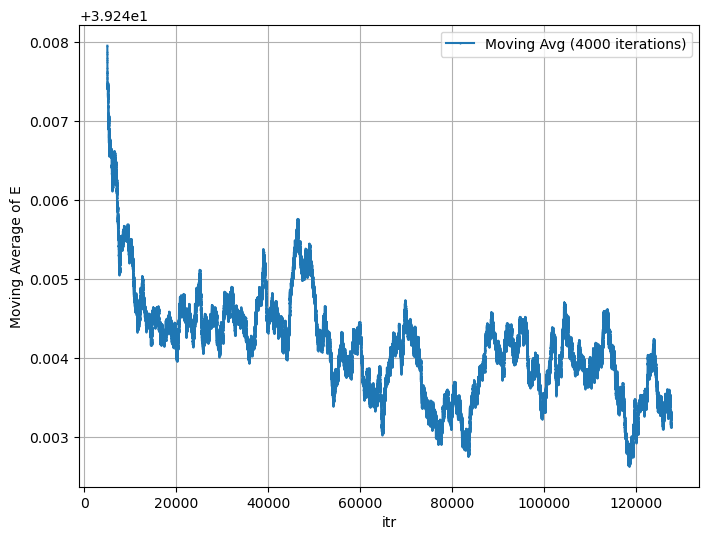

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `data` is a Pandas DataFrame
x = data.iloc[:, 0]  # First column (iterations)
y = data.iloc[:, 1]  # Second column (values)

# Compute the moving average over the last 100 iterations
y_moving_avg = y.rolling(window=5000).mean()

# Plot x vs moving average of y
plt.figure(figsize=(8, 6))
plt.plot(x, y_moving_avg, marker='o', linestyle='-', markersize=0.5, label='Moving Avg (4000 iterations)')
#plt.axhline(y=21.94179407905313, color='red', linestyle='--')
#plt.axhline(y=30.409901406794223 , color='red', linestyle='--')
#plt.axhline(y=43.663175583218 , color='red', linestyle='--')
#plt.axhline(y = 39.34564426575877, color='red', linestyle='--')
#plt.axhline(y = 38.88301983948136, color='red', linestyle='--')
#plt.axhline(y =  68.07983374411914, color='red', linestyle='--')
plt.xlabel('itr')
plt.ylabel('Moving Average of E')
plt.grid(True)
#plt.xlim(60000,120000)
#plt.ylim(44.075,44.1)
plt.legend()
plt.show()


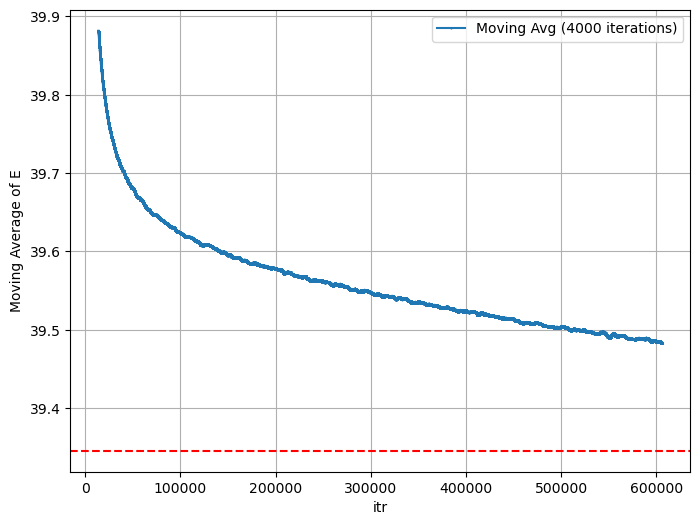

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `data` is a Pandas DataFrame
x = data.iloc[10000:, 0]  # First column (iterations)
y = data.iloc[10000:, 1]  # Second column (values)

# Compute the moving average over the last 100 iterations
y_moving_avg = y.rolling(window=4000).mean()

# Plot x vs moving average of y
plt.figure(figsize=(8, 6))
plt.plot(x, y_moving_avg, marker='o', linestyle='-', markersize=0.5, label='Moving Avg (4000 iterations)')
#plt.axhline(y=21.94179407905313, color='red', linestyle='--')
#plt.axhline(y=30.409901406794223 , color='red', linestyle='--')
#plt.axhline(y=43.663175583218 , color='red', linestyle='--')
plt.axhline(y = 39.34564426575877, color='red', linestyle='--')
#plt.axhline(y = 38.88301983948136, color='red', linestyle='--')
plt.xlabel('itr')
plt.ylabel('Moving Average of E')
plt.grid(True)
#plt.xlim(60000,120000)
#plt.ylim(44.075,44.1)
plt.legend()
plt.show()

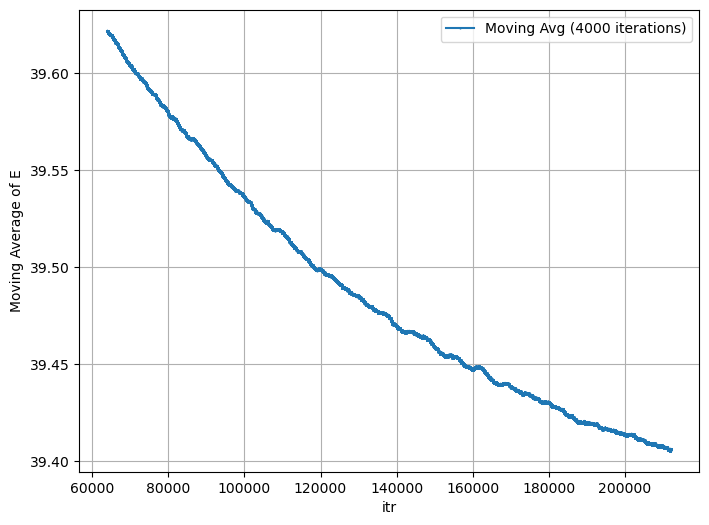

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `data` is a Pandas DataFrame
x = data.iloc[60000:, 0]  # First column (iterations)
y = data.iloc[60000:, 1]  # Second column (values)

# Compute the moving average over the last 100 iterations
y_moving_avg = y.rolling(window=4000).mean()

# Plot x vs moving average of y
plt.figure(figsize=(8, 6))
plt.plot(x, y_moving_avg, marker='o', linestyle='-', markersize=0.5, label='Moving Avg (4000 iterations)')
#plt.axhline(y=21.94179407905313, color='red', linestyle='--')
#plt.axhline(y=30.409901406794223 , color='red', linestyle='--')
#plt.axhline(y=43.663175583218 , color='red', linestyle='--')
#plt.axhline(y = 39.34564426575877, color='red', linestyle='--')
#plt.axhline(y = 38.88301983948136, color='red', linestyle='--')
plt.xlabel('itr')
plt.ylabel('Moving Average of E')
plt.grid(True)
#plt.xlim(60000,120000)
#plt.ylim(44.075,44.1)
plt.legend()
plt.show()

In [17]:
import os
import numpy as np

def load_recent_npz_files(folder, n):
    """
    Load the n most recent .npz files from a folder, sorted by their numeric part.

    Args:
        folder (str): Path to the folder containing .npz files.
        n (int): Number of recent files to load.

    Returns:
        list: A list of loaded .npz file data.
    """
    # List all .npz files in the folder
    npz_files = [f for f in os.listdir(folder) if f.endswith('.npz')]
    
    # Extract numeric parts from filenames and sort by them
    sorted_files = sorted(
        npz_files,
        key=lambda x: int(''.join(filter(str.isdigit, x))),
        reverse=True
    )
    
    # Select the n most recent files
    recent_files = sorted_files[:n]
    
    # Load the data from the selected files
    loaded_data = [np.load(os.path.join(folder, file), allow_pickle=True) for file in recent_files]
    print(loaded_data)
    return loaded_data

def load_recent_npz_files2(folder, n, m=None):
    """
    Load the n most recent .npz files or the mth most recent file from a folder, sorted by their numeric part.

    Args:
        folder (str): Path to the folder containing .npz files.
        n (int): Number of recent files to load.
        m (int, optional): Index of the mth most recent file to load (1-based index).

    Returns:
        list or np.ndarray: A list of loaded .npz file data if n files are loaded,
                            or a single .npz file data if m is specified.
    """
    # List all .npz files in the folder
    npz_files = [f for f in os.listdir(folder) if f.endswith('.npz')]
    
    # Extract numeric parts from filenames and sort by them
    sorted_files = sorted(
        npz_files,
        key=lambda x: int(''.join(filter(str.isdigit, x))),
        reverse=True
    )
    
    if m is not None:
        # Ensure m is within bounds
        if m < 1 or m > len(sorted_files):
            raise ValueError(f"Invalid value for m: {m}. Must be between 1 and {len(sorted_files)}.")
        
        # Load the mth most recent file (1-based index)
        mth_file = sorted_files[m - 1]
        print(mth_file)
        return [np.load(os.path.join(folder, mth_file), allow_pickle=True)]
    else:
        # Select the n most recent files
        recent_files = sorted_files[:n]
        print(recent_files)
        # Load the data from the selected files
        loaded_data = [np.load(os.path.join(folder, file), allow_pickle=True) for file in recent_files]
        return loaded_data


# Example usage:
# folder_path = "path/to/your/folder"
# recent_data = load_recent_npz_files(folder_path, 5)
# print(recent_data)


def gather_positions(loaded_files):
    """
    Gather all 'positions' from a list of loaded .npz files, reshape them, and flatten the list.

    Args:
        loaded_files (list): List of loaded .npz files.

    Returns:
        np.ndarray: A single 2D array of all reshaped 'positions' concatenated together.
    """
    positions_list = []
    
    for ckpt_data in loaded_files:
        # Extract positions from the current file
        positions = ckpt_data['data'].item()["positions"]
        
        # Reshape positions from (x, y, z) to (x*y, z)
        reshaped_positions = positions.reshape(-1, positions.shape[-1])
        positions_list.append(reshaped_positions)
    
    # Flatten the list of arrays into a single 2D array
    flattened_positions = np.vstack(positions_list)
    
    return flattened_positions

# Example usage:
# loaded_files = load_recent_npz_files("path/to/folder", 5)
# all_positions = gather_positions(loaded_files)
# print(all_positions.shape)  # Should be (total_rows, z)

In [18]:
ckpt_data = load_recent_npz_files2("/work/submit/ahmed95/data/8particles_withflux/0.25/",1)
#ckpt_data = load_recent_npz_files2('/ceph/submit/data/user/a/ahmed95/minimalChern_NN/ferminet_2025_10_03_20:44:22',1,60)
positions = gather_positions(ckpt_data)

""" ckpt_data = np.load('/work/submit/ahmed95/ferminet_ahmed/ferminet_2025_09_09_23:38:44/qmcjax_ckpt_121641.npz', allow_pickle=True)
positions = ckpt_data['data'].item()["positions"]
positions = positions.reshape(-1, positions.shape[-1]) """

['qmcjax_ckpt_019723.npz']


' ckpt_data = np.load(\'/work/submit/ahmed95/ferminet_ahmed/ferminet_2025_09_09_23:38:44/qmcjax_ckpt_121641.npz\', allow_pickle=True)\npositions = ckpt_data[\'data\'].item()["positions"]\npositions = positions.reshape(-1, positions.shape[-1]) '

In [9]:
ckpt_data

[NpzFile '/work/submit/ahmed95/minimalChern_NN/ferminet_2025_10_17_23:15:43/qmcjax_ckpt_449269.npz' with keys: t, data, params, opt_state, mcmc_width...]

In [19]:
def lattice_vecs(a1:jnp.ndarray, a2:jnp.ndarray,Tmatrix:jnp.ndarray) -> np.ndarray:
  "Return the basis T1,T2 of the super-cell built from the unit cell lattice vectors a1 and a2"
  T1 = Tmatrix[0,0]*a1 + Tmatrix[0,1]*a2
  T2 = Tmatrix[1,0]*a1 + Tmatrix[1,1]*a2
  return jnp.column_stack([T1, T2])
def reciprocal_vecs(a1: jnp.ndarray, a2: jnp.ndarray, Tmatrix: jnp.ndarray) -> jnp.ndarray:
  """
  Return the reciprocal basis vectors g1, g2 such that T_i · g_j = 2π δ_ij,
  where T1, T2 are the supercell vectors built from the unit cell vectors a1 and a2.
  """
  # Construct supercell lattice vectors T1, T2
  T1 = Tmatrix[0,0] * a1 + Tmatrix[0,1] * a2
  T2 = Tmatrix[1,0] * a1 + Tmatrix[1,1] * a2

  # Compute the oriented area A = T1 x T2 (scalar in 2D)
  A = T1[0] * T2[1] - T1[1] * T2[0]

  # Compute reciprocal vectors satisfying T_i · g_j = 2π δ_ij
  g1 = 2 * jnp.pi / A * jnp.array([ T2[1], -T2[0] ])
  g2 = 2 * jnp.pi / A * jnp.array([ -T1[1], T1[0] ])

  return jnp.column_stack([g1, g2])

In [20]:
a1 = jnp.array([jnp.sqrt(3)/2,-0.5])
a2 =   jnp.array([0,1])
Tmatrix = jnp.array([[4,0], [0, 6]])  # Identity matrix for unit cell
latticevecs = lattice_vecs(a1, a2, Tmatrix)
unitcellvecs = lattice_vecs(a1, a2, jnp.array([[1,0], [0, 1]]))  

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
def map_to_supercell(positions, lattice_vectors):
    """
    Maps flattened positions back to the supercell for a general lattice (e.g., triangular).

    Args:
        positions (np.ndarray): Flattened positions of shape (6,) for 3 particles (x1, y1, x2, y2, x3, y3).
        lattice_vectors (np.ndarray): 2x2 array representing the supercell lattice vectors.

    Returns:
        np.ndarray: Positions mapped back to the supercell, shape (3, 2).
    """
    # Reshape positions into (num_particles, 2)
    num_particles = len(positions) // 2
    reshaped_positions = positions.reshape((num_particles, 2))
    
    # Compute the inverse of the lattice vectors
    lattice_inverse = np.linalg.inv(lattice_vectors)
    
    # Convert positions to fractional coordinates
    fractional_coords = np.dot(reshaped_positions, lattice_inverse.T)
    # Map fractional coordinates back to the unit cell (0 to 1)
    fractional_coords = np.mod(fractional_coords, 1.0)
    # Convert back to Cartesian coordinates
    supercell_positions = np.dot(fractional_coords, lattice_vectors.T) 
    
    return supercell_positions

def plot_density_with_unit_cells(samples, supercell_vectors, unit_cell_vectors, bins=100):
    """
    Plots the density based on the mapped positions and overlays parallelograms for the supercell and a smaller unit cell.

    Args:
        samples (np.ndarray): Array of shape (1, 1024, 6), containing flattened positions for all samples.
        supercell_vectors (np.ndarray): 2x2 array representing the supercell lattice vectors.
        unit_cell_vectors (np.ndarray): 2x2 array representing the smaller unit cell lattice vectors.
        bins (int): Number of bins for the 2D histogram.
    """
    # Ensure samples is of shape (1, 1024, 6)
   # assert samples.shape[0] == 1 and samples.shape[2] == 6, "Samples must have shape (1, 1024, 6)"
    
    # Extract the 1024 samples
    #samples = samples[0]  # Shape becomes (1024, 6)
    
    # Map all samples to the supercell
    mapped_positions = []
    for sample in samples:
        mapped_positions.append(map_to_supercell(sample, supercell_vectors))
    mapped_positions = np.vstack(mapped_positions)  # Combine all samples into one array
    
    # Create a 2D histogram for density
    x, y = mapped_positions[:, 0], mapped_positions[:, 1]
    
    # Define the supercell bounds
    supercell_v1 = supercell_vectors[:,0]
    supercell_v2 = supercell_vectors[:,1]
    supercell_vertices = np.array([[0, 0], supercell_v1, supercell_v1 + supercell_v2, supercell_v2])  # Vertices of the supercell
    x_min, x_max = np.min(supercell_vertices[:, 0]), np.max(supercell_vertices[:, 0])
    y_min, y_max = np.min(supercell_vertices[:, 1]), np.max(supercell_vertices[:, 1])
    
    # Compute the histogram within the supercell bounds
    density, xedges, yedges = np.histogram2d(
        x, y, bins=bins, range=[[x_min, x_max], [y_min, y_max]]
    )
    
    # Plot the density
    plt.figure(figsize=(8, 6))
    plt.imshow(
        density.T,
        origin='lower',
        extent=[x_min, x_max, y_min, y_max],
        aspect='auto',
        cmap='plasma',
    )
    plt.colorbar(label='Density')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Density Plot with Supercell and Unit Cell Parallelograms')
    
    # Overlay the supercell parallelogram
    supercell_parallelogram = np.array([[0, 0], supercell_v1, supercell_v1 + supercell_v2, supercell_v2, [0, 0]])  # Close the supercell
    plt.plot(supercell_parallelogram[:, 0], supercell_parallelogram[:, 1], color='red', label='Supercell')
    
    # Overlay the unit cell parallelogram
    unit_cell_v1 = unit_cell_vectors[:,0]
    unit_cell_v2 = unit_cell_vectors[:,1]
    unit_cell_parallelogram = np.array([[0, 0], unit_cell_v1, unit_cell_v1 + unit_cell_v2, unit_cell_v2, [0, 0]])  # Close the unit cell
    plt.plot(unit_cell_parallelogram[:, 0], unit_cell_parallelogram[:, 1], color='blue', linestyle='--', label='Unit Cell')
    
    # Add a legend for the parallelograms
    plt.legend()
    
    plt.show()
def plot_density_with_circular_bins(samples, supercell_vectors, unit_cell_vectors, bins=100):
    """
    Plots the density based on the mapped positions using circular bins and overlays parallelograms for the supercell and a smaller unit cell.

    Args:
        samples (np.ndarray): Array of shape (1, 1024, 6), containing flattened positions for all samples.
        supercell_vectors (np.ndarray): 2x2 array representing the supercell lattice vectors.
        unit_cell_vectors (np.ndarray): 2x2 array representing the smaller unit cell lattice vectors.
        bins (int): Number of circular bins for the radial density.
    """
    # Extract the 1024 samples
    #samples = samples[0]  # Shape becomes (1024, 6)
    
    # Map all samples to the supercell
    mapped_positions = []
    for sample in samples:
        mapped_positions.append(map_to_supercell(sample, supercell_vectors))
    mapped_positions = np.vstack(mapped_positions)  # Combine all samples into one array
    
    # Compute the radial distance of each point from the origin
    radial_distances = np.linalg.norm(mapped_positions, axis=1)
    
    # Define the maximum radius (diagonal of the supercell)
    supercell_v1 = supercell_vectors[:,0]
    supercell_v2 = supercell_vectors[:,1]
    max_radius = np.linalg.norm(supercell_v1 + supercell_v2)
    
    # Compute the histogram for radial density
    density, bin_edges = np.histogram(radial_distances, bins=bins, range=(0, max_radius))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Normalize the density by the area of each circular bin
    bin_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    normalized_density = density / bin_areas
    
    """# Plot the radial density
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, normalized_density, label='Radial Density', color='purple')
    plt.xlabel('Radius')
    plt.ylabel('Density')
    plt.title('Radial Density with Circular Bins')
    plt.grid(True)
    plt.legend()"""
    
    # Overlay the supercell and unit cell parallelograms
    plt.figure(figsize=(8, 6))
    x, y = mapped_positions[:, 0], mapped_positions[:, 1]
    plt.scatter(x, y, s=1, alpha=0.5, label='Mapped Positions')
    
    # Overlay the supercell parallelogram
    supercell_vertices = np.array([[0, 0], supercell_v1, supercell_v1 + supercell_v2, supercell_v2, [0, 0]])  # Close the supercell
    plt.plot(supercell_vertices[:, 0], supercell_vertices[:, 1], color='red', label='Supercell')
    
    # Overlay the unit cell parallelogram
    unit_cell_v1 = unit_cell_vectors[0]
    unit_cell_v2 = unit_cell_vectors[1]
    unit_cell_parallelogram = np.array([[0, 0], unit_cell_v1, unit_cell_v1 + unit_cell_v2, unit_cell_v2, [0, 0]])  # Close the unit cell
    plt.plot(unit_cell_parallelogram[:, 0], unit_cell_parallelogram[:, 1], color='blue', linestyle='--', label='Unit Cell')
    
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mapped Positions with Supercell and Unit Cell')
    plt.legend()
    plt.show()

def plot_density_outside_supercell(samples, supercell_vectors, unit_cell_vectors, bins=100, replication_range=1):
    """
    Plots the density based on the mapped positions outside the supercell by replicating the data using periodicity.

    Args:
        samples (np.ndarray): Array of shape (1, 1024, 6), containing flattened positions for all samples.
        supercell_vectors (np.ndarray): 2x2 array representing the supercell lattice vectors.
        unit_cell_vectors (np.ndarray): 2x2 array representing the smaller unit cell lattice vectors.
        bins (int): Number of circular bins for the radial density.
        replication_range (int): Number of replications in each direction (positive and negative) for periodicity.
    """
    # Extract the 1024 samples
    #samples = samples[0]  # Shape becomes (1024, 6)
    
    # Map all samples to the supercell
    mapped_positions = []
    for sample in samples:
        mapped_positions.append(map_to_supercell(sample, supercell_vectors))
    mapped_positions = np.vstack(mapped_positions)  # Combine all samples into one array
    
    # Generate replicated positions outside the supercell
    replicated_positions = []
    for i in range(-replication_range, replication_range + 1):
        for j in range(-replication_range, replication_range + 1):
            shift = i * supercell_vectors[:,0] + j * supercell_vectors[:,1]
            replicated_positions.append(mapped_positions + shift)
    replicated_positions = np.vstack(replicated_positions)  # Combine all replicated positions
    
    # Compute the radial distance of each point from the origin
    radial_distances = np.linalg.norm(replicated_positions, axis=1)
    
    # Define the maximum radius (diagonal of the supercell)
    supercell_v1 = supercell_vectors[:,0]
    supercell_v2 = supercell_vectors[:,1]
    max_radius = np.linalg.norm(supercell_v1 + supercell_v2) * replication_range
    
    # Compute the histogram for radial density
    density, bin_edges = np.histogram(radial_distances, bins=bins, range=(0, max_radius))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Normalize the density by the area of each circular bin
    bin_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    normalized_density = density / bin_areas
    
    # Overlay the replicated positions and supercell
    plt.figure(figsize=(8, 6))
    x, y = replicated_positions[:, 0], replicated_positions[:, 1]
    plt.scatter(x, y, s=1, alpha=0.5, label='Positions')
    
    # Overlay the supercell parallelogram
    supercell_vertices = np.array([[0, 0], supercell_v1, supercell_v1 + supercell_v2, supercell_v2, [0, 0]])  # Close the supercell
    plt.plot(supercell_vertices[:, 0], supercell_vertices[:, 1], color='black', label='Supercell')
    
    # Overlay the unit cell parallelogram
    unit_cell_v1 = unit_cell_vectors[:,0]
    unit_cell_v2 = unit_cell_vectors[:,1]
    unit_cell_parallelogram = np.array([[0, 0], unit_cell_v1, unit_cell_v1 + unit_cell_v2, unit_cell_v2, [0, 0]])  # Close the unit cell
    plt.plot(unit_cell_parallelogram[:, 0], unit_cell_parallelogram[:, 1], color='blue', linestyle='--', label='Unit Cell')
    
    # Set aspect ratio to 1
    plt.axis('equal')
    plt.ylim(-4,6)
    plt.xlim(0,3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Positions')
    plt.legend()
    #plt.axis('off')
    #plt.savefig("plots_paper/density_8particles_onethird.png", dpi = 1200, bbox_inches="tight")
    plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


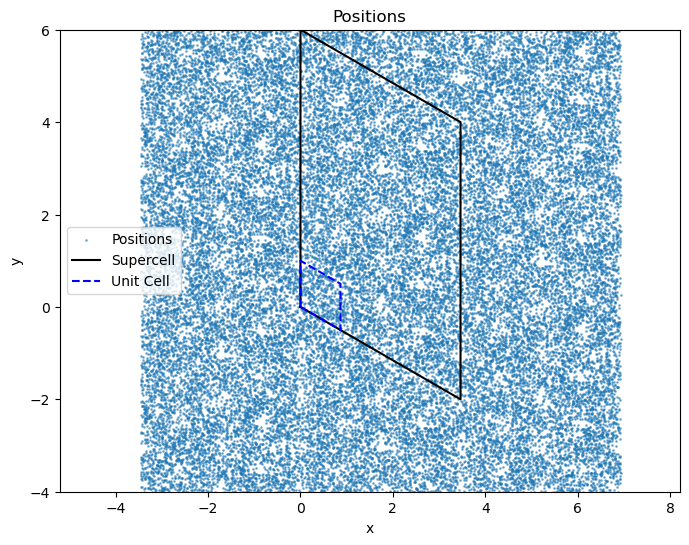

In [22]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


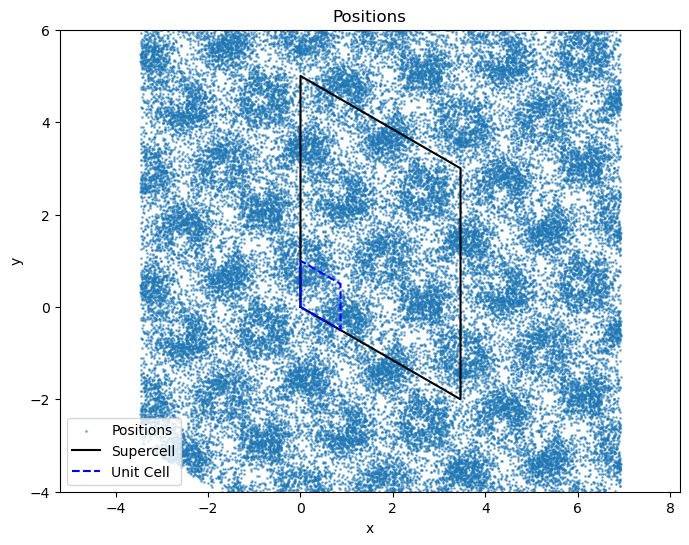

In [27]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


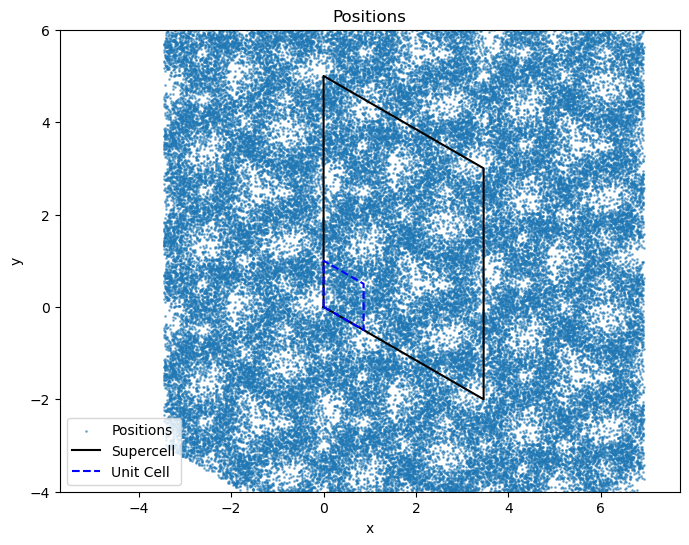

In [74]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


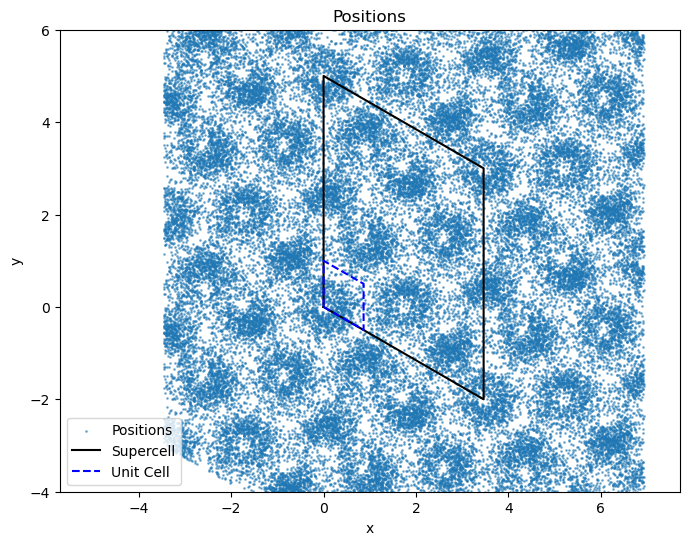

In [125]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


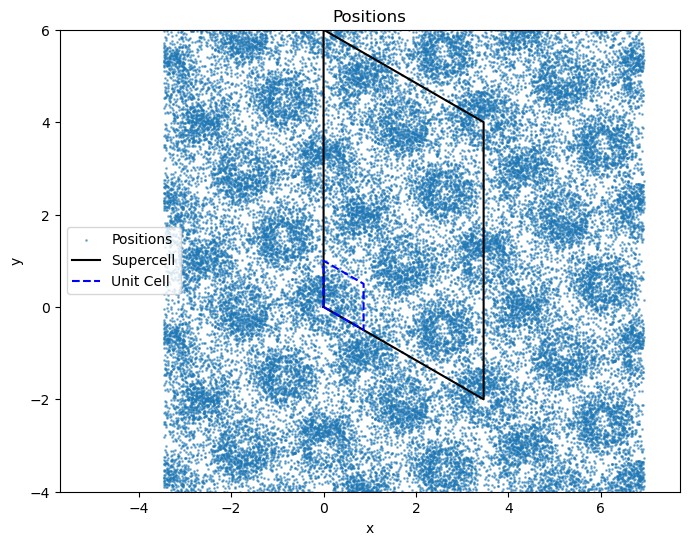

In [48]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


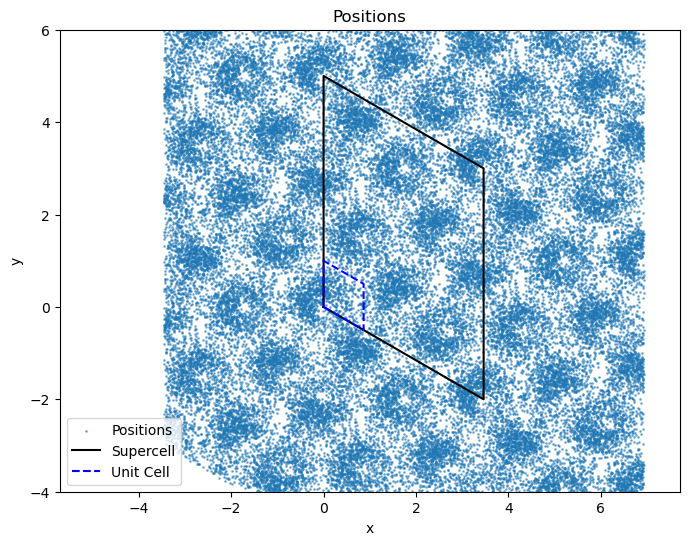

In [93]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


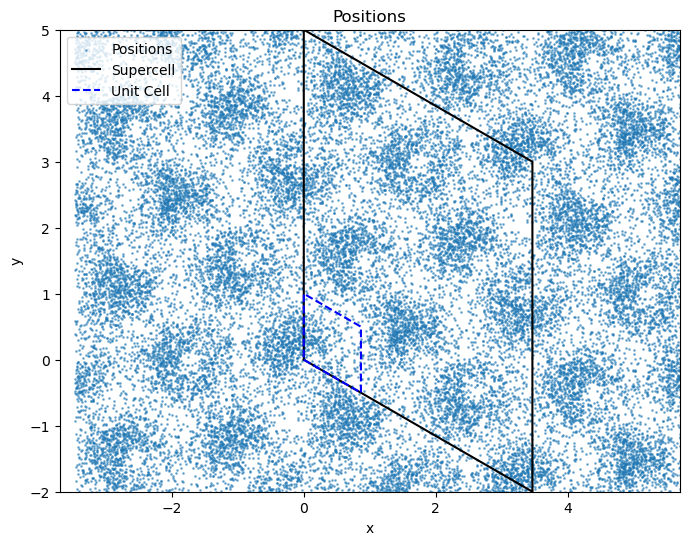

In [49]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


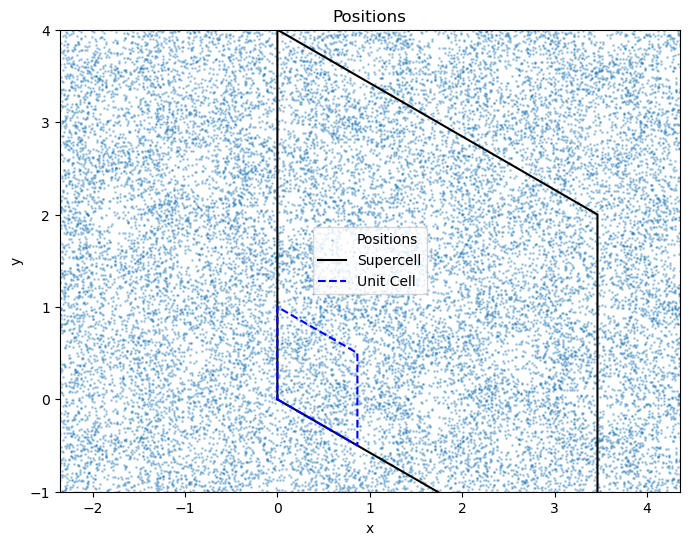

In [21]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


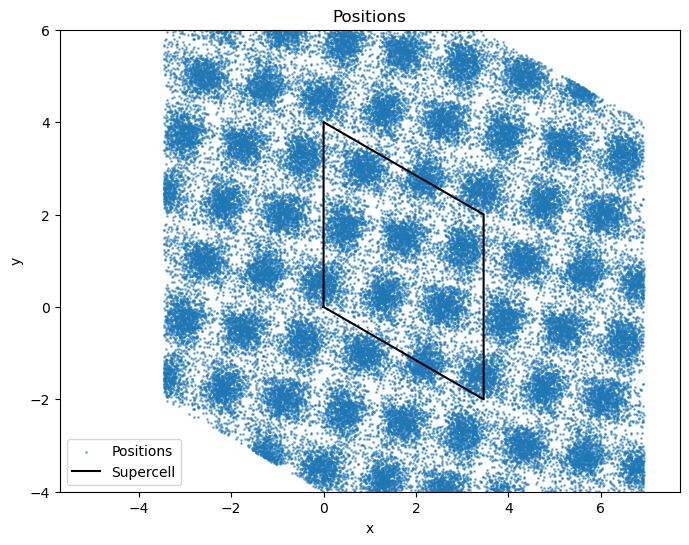

In [35]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


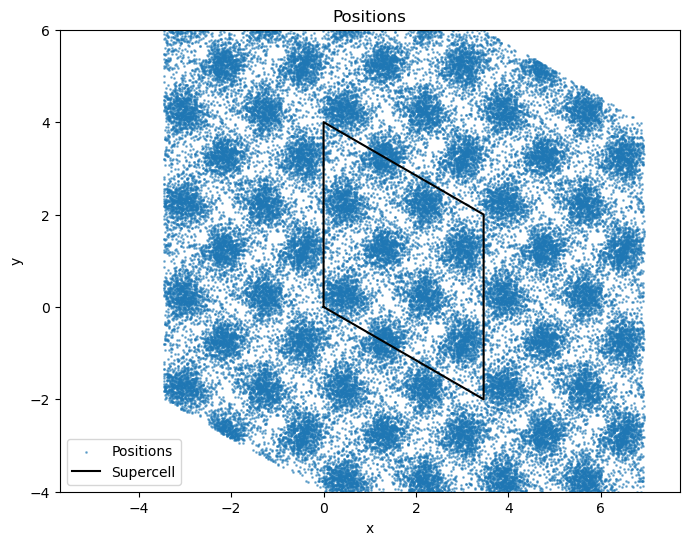

In [12]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


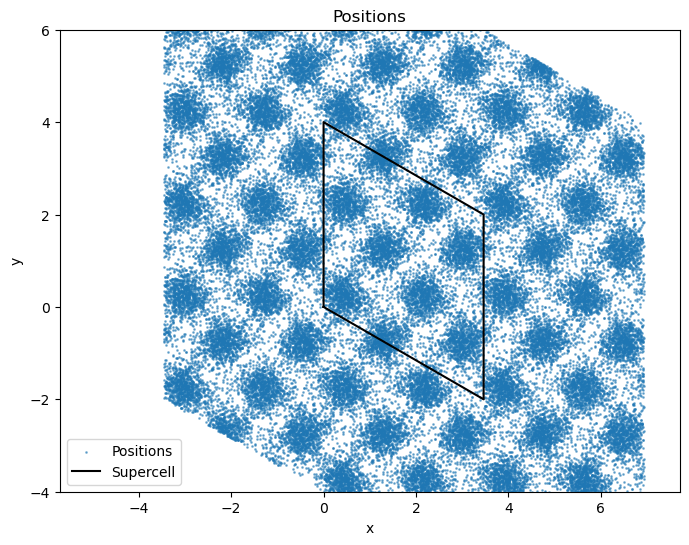

In [12]:
# Example lattice vectors (orthogonal supercell)
#lattice_vectors = np.array([[10.0, 0.0], [0.0, 10.0]])

# Example samples of shape (1, 1024, 6)
#samples = np.random.uniform(0, 30, size=(1, 1024, 6))  # Random example data

# Plot the density
plot_density_outside_supercell(positions, latticevecs,unitcellvecs,40,1)

In [27]:
import numpy as np

def compute_density_delta_product(samples, point, bandwidth=1.0, lattice_vectors=None):
    """
    Compute the real-space density at a single point from samples of positions
    using a product of delta function approximations for each coordinate.

    Parameters:
        samples (np.ndarray): Array of shape (N, N_p, ndim) where N is the number of samples,
                              N_p is the number of particles per sample, and ndim is the dimensionality.
        point (np.ndarray): Array of shape (ndim,) representing the point where density is computed.
        bandwidth (float): Bandwidth parameter for the Gaussian kernel (delta function approximation).
        lattice_vectors (np.ndarray): 2x2 array representing the supercell lattice vectors.

    Returns:
        float: The computed density at the given point.
    """
    samples = np.asarray(samples)
    point = np.asarray(point)
    
    # Ensure the dimensions match
    if samples.shape[2] != point.shape[0]:
        raise ValueError("Dimensionality of samples and point must match.")
    
    # Map samples and point into the supercell if lattice_vectors are provided
    if lattice_vectors is not None:
        mapped_samples = np.zeros_like(samples)  # Create a new array for mapped positions
        for i in range(samples.shape[0]):  # Iterate over all samples
            for j in range(samples.shape[1]):  # Iterate over all particles
                # Flatten particle position and map to supercell
                mapped_samples[i, j] = map_to_supercell(samples[i, j].flatten(), lattice_vectors)
        samples = mapped_samples  # Replace samples with the mapped version
        # Map the point to the supercell
        point = map_to_supercell(point.flatten(), lattice_vectors)
    
    # Compute the Gaussian approximation to the delta function for each coordinate
    deltas = np.exp(-((samples - point) ** 2) / (2 * bandwidth ** 2))
    
    # Take the product across all dimensions for each particle
    delta_products = np.prod(deltas, axis=2)  # Shape: (N, N_p)
    
    # Sum over all particles and samples
    total_density = np.sum(delta_products)
    
    # Normalize by the bandwidth, number of particles, and number of samples
    normalization = (samples.shape[0] * samples.shape[1] * (bandwidth ** samples.shape[2]) * (2 * np.pi) ** (samples.shape[2] / 2))
    density = total_density / normalization
    
    return density

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Define the grid for the 2D space
x_min, x_max = 0.0, 5.0  # Define the range for x-axis
y_min, y_max = 0.0, 5.0  # Define the range for y-axis
grid_size = 50  # Number of points along each axis

x = np.linspace(x_min, x_max, grid_size)
y = np.linspace(y_min, y_max, grid_size)
X, Y = np.meshgrid(x, y)  # Create a 2D grid

# Compute the density at each grid point
density = np.zeros_like(X)
for i in range(grid_size):
    print(i)
    for j in range(grid_size):
        point = jnp.array([X[i, j], Y[i, j]])
        density[i, j] = compute_density_delta_product(reshapedpos, point, 0.1, latticevecs)

# Plot the density as a 2D heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, density, levels=50, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Density Distribution')
plt.show()

0


NameError: name 'reshapedpos' is not defined

In [111]:
reshapedpos = positions[0].reshape((positions[0].shape[0], 3, 2))

In [122]:
nk = compute_momentum_distribution(reshapedpos, jnp.array([0,0]), latticevecs)
print(nk)

0.3849001834245888


In [132]:
from ferminet import psiformer

AttributeError: module 'jax.numpy' has no attribute 'DeviceArray'

In [255]:
import numpy as np
import matplotlib.pyplot as plt

def compute_pair_correlation_supercell(positions, supercell_vectors, bins=100, max_distance=None):
    """
    Compute the pair correlation function for particles in a supercell.

    Parameters:
    - positions: Array of shape (n_particles, 2) containing particle positions in Cartesian coordinates.
    - supercell_vectors: Array of shape (2, 2) defining the supercell lattice vectors.
    - bins: Number of bins for the histogram.
    - max_distance: Maximum distance to consider for the pair correlation function.

    Returns:
    - r: Array of bin centers.
    - g_r: Pair correlation function values.
    """
    N = len(positions)  # Number of particles
    v1, v2 = supercell_vectors  # Supercell lattice vectors
    supercell_area = np.abs(np.cross(v1, v2))  # Area of the supercell
    density = N / supercell_area  # Particle density

    # Compute the inverse lattice vectors for periodic boundary conditions
    inv_lattice = np.linalg.inv(supercell_vectors)

    if max_distance is None:
        max_distance = 0.5 * np.sqrt(supercell_area)

    # Map all particle positions back to the supercell
    fractional_coords = np.dot(positions, inv_lattice.T) % 1  # Map to unit cell
    positions_mapped = np.dot(fractional_coords, supercell_vectors.T)  # Back to Cartesian coordinates

    distances = []

    # Compute pairwise distances with periodic boundary conditions
    for i in range(N):
        for j in range(i + 1, N):
            displacement = positions_mapped[j] - positions_mapped[i]
            fractional_coords = np.dot(displacement, inv_lattice.T)
            fractional_coords -= np.round(fractional_coords)  # Apply periodic boundary conditions
           # displacement = np.dot(fractional_coords, supercell_vectors.T)
            distance = np.linalg.norm(displacement)
            if distance <= max_distance:
                distances.append(distance)

    distances = np.array(distances)
    hist, bin_edges = np.histogram(distances, bins=bins, range=(0, max_distance))
    r = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    g_r = hist / (bin_areas * density * N)

    return r, g_r


def scatter_relative_distances_supercell(positions, supercell_vectors, bins=100):
    """
    Compute and visualize the relative distances between particles in a supercell,
    replicating them with supercell periodicity in a 2D scatter plot.

    Parameters:
    - positions: Array of shape (n_particles, 2) containing particle positions in Cartesian coordinates.
    - supercell_vectors: Array of shape (2, 2) defining the supercell lattice vectors.
    - bins: Number of bins for the relative distances (used for coloring).

    Returns:
    - None (displays a 2D scatter plot).
    """
    N = len(positions)  # Number of particles
    v1, v2 = supercell_vectors  # Supercell lattice vectors
    inv_lattice = np.linalg.inv(supercell_vectors)  # Inverse lattice for periodic boundary conditions

    # Map all particle positions back to the supercell
    fractional_coords = np.dot(positions, inv_lattice.T) % 1  # Map to unit cell
    positions_mapped = np.dot(fractional_coords, supercell_vectors.T)  # Back to Cartesian coordinates

    displacement_vectors = []

    # Compute pairwise displacement vectors with periodic boundary conditions
    for i in range(N):
        for j in range(i + 1, N):
            displacement = positions_mapped[j] - positions_mapped[i]
            fractional_coords = np.dot(displacement, inv_lattice.T)
            fractional_coords -= np.round(fractional_coords)  # Apply periodic boundary conditions
            displacement = np.dot(fractional_coords, supercell_vectors.T)
            displacement_vectors.append(displacement)

    displacement_vectors = np.array(displacement_vectors)

    # Replicate displacements with supercell periodicity
    replicated_displacements = []
    for dx in range(-1, 2):  # Replicate in x-direction
        for dy in range(-1, 2):  # Replicate in y-direction
            shift = dx * v1 + dy * v2
            replicated_displacements.append(displacement_vectors + shift)

    replicated_displacements = np.vstack(replicated_displacements)

    # Compute distances for coloring
    distances = np.linalg.norm(replicated_displacements, axis=1)
    max_distance = np.max(distances)
    bin_edges = np.linspace(0, max_distance, bins + 1)
    bin_indices = np.digitize(distances, bin_edges) - 1  # Bin indices for coloring

    # Create a 2D scatter plot
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        replicated_displacements[:, 0],
        replicated_displacements[:, 1],
        c=bin_indices,
        cmap="viridis",
        s=10,
        alpha=0.7
    )
    plt.colorbar(scatter, label="Distance Bin")
    plt.title("2D Scatter Plot of Relative Distances with Supercell Periodicity")
    plt.xlabel("x displacement")
    plt.ylabel("y displacement")
    plt.axis("equal")
    plt.show()



In [256]:
# Example positions array and supercell lattice vectors
#positions = np.random.rand(1, 10, 4 * 2)  # 10 configurations, 4 particles, 2D positions
supercell_vectors = latticevecs  # Example supercell geometry

# Reshape positions to (n_configs, n_particles, 2)
n_configs = positions.shape[1]
n_particles = positions.shape[2] // 2
positions_n = positions.reshape(n_configs, n_particles, 2)

# Map positions back to the unit cell
inv_supercell_vectors = np.linalg.inv(supercell_vectors)
positions_unit_cell = np.dot(positions_n, inv_supercell_vectors.T) % 1
positions_cartesian = np.dot(positions_unit_cell, supercell_vectors.T)

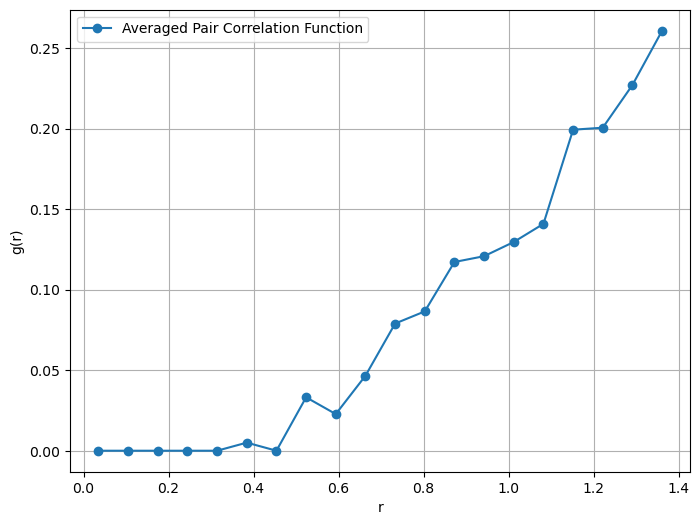

In [257]:
# Compute and average the pair correlation function
all_g_r = []
for config_idx in range(n_configs):
    r, g_r = compute_pair_correlation_supercell(positions_n[config_idx], supercell_vectors, 20)
    
    # Ensure g(r) vanishes at r = 0
   # g_r[0] = 0  # Set the first bin to zero explicitly
    
    all_g_r.append(g_r)

# Average g(r) over all configurations
g_r_avg = np.mean(all_g_r, axis=0)

# Plot the averaged pair correlation function
plt.figure(figsize=(8, 6))
plt.plot(r, g_r_avg, label='Averaged Pair Correlation Function', marker="o")
plt.xlabel('r')
plt.ylabel('g(r)')
plt.grid(True)
plt.legend()
plt.show()

In [108]:
positions.shape

(1, 1024, 8)